In [89]:
import os, warnings, sys, yaml
from stream2segment.process.db import get_session
from stream2segment.io.db.models import Station, Segment, concat, Channel
from stream2segment.io.utils import loads_inv
# warnings.simplefilter('always')
from IPython.display import clear_output

_fle = os.path.abspath(os.path.join('.', 'jnconfig.yaml'))
assert os.path.isfile(_fle)
with open(_fle, "r") as _:
    jnconfig = yaml.safe_load(_)

dbpath_old = jnconfig['dbpath_old']
dbpath_new = jnconfig['dbpath_new']

with open(os.path.join(os.getcwd(), 's2s_2018_01_smod_gtk.txt')) as _:
    content1 = _.read().split("\n")
with open(os.path.join(os.getcwd(), 's2s_2018_01_smod_ita.txt')) as _:
    content2 = _.read().split("\n")

data_seed_ids = sorted(set(_ for _ in chain(content1, content2) if _))
# data_seed_id_tostr = " ".join(('"%s"' % _) for _ in data_seed_ids)
# print('  data_seed_id: \'%s\'' % data_seed_id_tostr)

print('%d good channels from list. Checking names' % len(data_seed_ids))
sta_locations = set()
data_seed_ids_tmp = list(data_seed_ids)
data_seed_ids = []
try:
    for i, data_seed_id in enumerate(data_seed_ids_tmp):
        clear_output(wait=True)
        print("%.0f%% done" % (100*i/len(data_seed_ids_tmp)))
        data_seed_id_ = data_seed_id.replace('.NA.', '..').replace('.0.', '.00.').replace('.1.', '.01.')
        segment = sess.query(Segment).filter(
                    (Segment.data_seed_id == data_seed_id_) # Station.segments.any(Segment.has_data) &
                    & (Segment.has_data == True)
                    # & (Station.start_time == stime)
                    # & (Station.has_inventory==True) # Station.segments.any(Segment.has_data)
                    # & Channel.channel.in_(channels)
                ).limit(1).options(load_only(Segment.id)).first()
        if segment is None:
            raise Exception(data_seed_id + ' not found')
        data_seed_ids.append(data_seed_id_)
        sta_locations.add((segment.station.id, segment.station.longitude, segment.station.latitude))
finally:
    sess.close()

data_seed_ids = sorted(set(data_seed_ids))
print("%d good channels found" % len(data_seed_ids))

100% done


TypeError: unsupported operand type(s) for +: 'int' and 'str'

STATIONS LOCATIONS


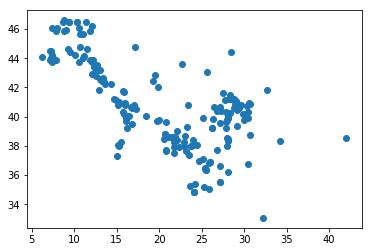

In [90]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

print('STATIONS LOCATIONS')
fig = plt.scatter([_[1] for _ in sta_locations], [_[2] for _ in sta_locations])
plt.show()

In [95]:
import dateutil.parser
from collections import defaultdict

# wrong_stations_list = '''
# CH.GRIMS.2011-11-09T00:00:00.HHE
# CH.GRIMS.2011-11-09T00:00:00.HHN
# CH.GRIMS.2011-11-09T00:00:00.HHZ
# CH.GRIMS.2015-10-30T10:50:00.HHE
# CH.GRIMS.2015-10-30T10:50:00.HHN
# CH.GRIMS.2015-10-30T10:50:00.HHZ
# SK.MODS.2004-03-17T00:00:00.HHE
# SK.MODS.2004-03-17T00:00:00.HHN
# SK.MODS.2004-03-17T00:00:00.HHZ
# SK.ZST.2004-03-17T00:00:00.HHE
# SK.ZST.2004-03-17T00:00:00.HHN
# SK.ZST.2004-03-17T00:00:00.HHZ
# FR.PYLO.2010-01-17T10:00:00.HNE
# FR.PYLO.2010-01-17T10:00:00.HNN
# FR.PYLO.2010-01-17T10:00:00.HNZ
# '''.strip().split('\n')

# wrong_stations_dict = defaultdict(list)
# for _ in wrong_stations_list:
#     wrong_stations_dict[".".join(_.split('.')[:3])].append(_.split('.')[-1])
# wrong_stations_set = set(wrong_stations_list)


wrong_stations_dict = {
    'CH.GRIMS.2011-11-09T00:00:00': ['HHE', 'HHN', 'HHZ'],
    'CH.GRIMS.2015-10-30T10:50:00': ['HHE', 'HHN', 'HHZ'],
    'SK.MODS.2004-03-17T00:00:00': ['HHE', 'HHN', 'HHZ'],
    'SK.ZST.2004-03-17T00:00:00': ['HHE', 'HHN', 'HHZ'],
    'FR.PYLO.2010-01-17T10:00:00': ['HNE', 'HNN', 'HNZ']
}

print('Finding stations with the wrong inventories on old database, and adding them to the list of channels')
print('')
wrongstaids = defaultdict(list)
try:
    for stakey, channels in wrong_stations_dict.items():
        net, sta, stime = stakey.split('.')
        stime = dateutil.parser.parse(stime)
        channels_ = sess.query(Channel).join(Channel.station).filter(
                    (Station.netsta_code == "%s.%s" % (net, sta)) # Station.segments.any(Segment.has_data) &
                    & (Station.start_time == stime)
                    & (Station.has_inventory==True) # Station.segments.any(Segment.has_data)
                    & Channel.channel.in_(channels)
                ).all()
        for cha in channels_:
            inv_filename = cha.station.network + '.' + cha.station.station + '.' + cha.station.start_time.isoformat()
            cha_key = cha.station.network + '.' + cha.station.station + '.' + cha.location + '.' + cha.channel
            if cha.station.id not in wrongstaids:
                wrongstaids[cha.station.id] = {}
            wrongstaids[cha.station.id][cha_key] =  inv_filename + '.xml'
    print("%d wrong station ids found (mapped to local wrong inventory file)" % len(wrongstaids) )
finally:
    sess.close()

for key, val in wrongstaids.items():
    for key2, val2 in val.items():
        data_seed_ids.append(key2)
data_seed_ids = sorted(data_seed_ids)

Finding stations with the wrong inventories on old database, and adding them to the list of channels

5 wrong station ids found (mapped to local wrong inventory file)


In [96]:
from obspy import Trace, Stream, UTCDateTime
import numpy as np
from sqlalchemy import func, distinct
from sqlalchemy.orm import load_only
import random

# get unique stations:
from itertools import chain
stations = set()
for _ in data_seed_ids:
    station = ".".join(_.split('.')[:2])
    if station not in stations:
        stations.add(station)

stations = sorted(stations)
print('%d unique stations found. Querying those with inventories having both accelerometers and velocimenters' % len(stations))
print('')
sess = get_session(dbpath_new)
sta_vel_acc = {}
try:
    stations_ = sess.query(Station).join(Station.channels).filter(
                (Station.netsta_code.in_(list(stations))) # Station.segments.any(Segment.has_data) &
                & (Station.has_inventory==True) # Station.segments.any(Segment.has_data)
                & (Station.channels.any(Channel.instrument_code.in_(["N", "L" ,"G"])))
                & (Station.channels.any(~Channel.instrument_code.in_(["N", "L" ,"G"])))
            ).options(load_only(Station.id, Station.network, Station.station, Station.start_time)).\
            order_by(Station.network, Station.station, Station.start_time)
    # print(str(stations_))
    stations_ = stations_.all()
    for _ in stations_:
        sta_vel_acc[_.id] = "%s.%s.%s" % (_.network, _.station, _.start_time.isoformat())
        # print("  %d:  \"%s.%s.%s\"" % (_.id, _.network, _.station, _.start_time.isoformat()))
finally:
    sess.close()
print('%d stations with inventories both accel and velocimeter found' % (len(sta_vel_acc)))

194 unique stations found. Querying those with inventories having both accelerometers and velocimenters

53 stations with inventories both accel and velocimeter found


In [87]:
# print inventories with accelerometer and velocimeter
print('\n# List of station ids whose inventory has both accel. and veloc. (use a dict for faster search, dict values are supposed to be ignored)')
print('\nstation_ids_both_accel_veloc:')
for id, key in sta_vel_acc.items():
    # sta_vel_acc[_.id] = "\"%s.%s.%s\"" % (_.network, _.station, _.start_time.isoformat())
    print("  %d:  \"%s\"" % (id, key))
    
# wrong sta ids:
print('\n# List of station ids with a wrong inventory saved locally. Each id is mapped to a channel mapped in turn to the relative file name')
print('\nstation_ids_with_wrong_local_inventory:')
for key, val in wrongstaids.items():
    print("  %s:" % key)
    for key2, val2 in val.items():
        print('    %s: "%s"' % (key2, val2))
        
# print data seed ids. First merge the wrong sta ids
print('\n# Segment select data_seed_id')
data_seed_id_tostr = " ".join(('"%s"' % _) for _ in data_seed_ids)
print('\n  data_seed_id: \'%s\'' % data_seed_id_tostr)



# List of station ids whose inventory has both accel. and veloc. (use a dict for faster search, dict values are supposed to be ignored)

station_ids_both_accel_veloc:
  3937:  "BS.BLKB.2012-11-20T00:00:00"
  5795:  "CH.DIX.1999-08-04T00:00:00"
  5796:  "CH.DIX.2010-06-24T00:00:00"
  5797:  "CH.DIX.2016-11-03T17:20:00"
  5824:  "CH.FUSIO.2005-12-01T00:00:00"
  5825:  "CH.FUSIO.2008-10-21T00:00:00"
  5826:  "CH.FUSIO.2017-08-16T19:00:00"
  5860:  "CH.MMK.2017-10-12T16:00:00"
  5861:  "CH.MMK.2018-07-02T13:00:00"
  5878:  "CH.NALPS.2017-08-24T10:00:00"
  516:  "CL.ROD3.2014-03-14T14:00:00"
  3502:  "CQ.OSC2.2015-07-17T00:00:00"
  674:  "FR.ESCA.2008-06-11T11:30:00"
  678:  "FR.ESCA.2012-03-28T10:10:00"
  681:  "FR.ESCA.2014-07-30T12:30:00"
  759:  "FR.MON.2008-08-13T10:30:00"
  760:  "FR.MON.2008-12-18T08:30:00"
  761:  "FR.MON.2010-01-07T10:30:00"
  707:  "FR.MON.2010-01-22T09:15:00"
  762:  "FR.MON.2016-06-27T12:00:00"
  814:  "FR.OGDI.2010-02-21T00:00:00"
  966:  "FR.SAOF.2008-02-01T1

In [ ]:
## Rule: take segment. Process, label = 0 (good). Then: 
#  it is one of the wrong inventories: -> calculate with the wrong inventory (label=1, outlier)
#  it is one with inventory also for velocimenter, take all velocimeters,
#     replace response and calculate with the wrong inventory (label=1)
#  For gain in 0.1, 0.5 2 5 10 calculate also with different gain